## Кривоногов Н.В., Глубокое обучение в компьютерном зрении. Интерактивный курс, практическое задание № 7

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH

Библиотеки: [Python, Tensorflow]

Спасибо Алексею за помощь с разбором кода.

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
if 0:
    !pip install scikit-video==1.1.11
import skvideo.io

## Загрузка и распаковка датасета KTH

In [4]:
if 0:
    !wget http://www.csc.kth.se/cvap/actions/walking.zip
    !wget http://www.csc.kth.se/cvap/actions/jogging.zip
    !wget http://www.csc.kth.se/cvap/actions/running.zip
    !wget http://www.csc.kth.se/cvap/actions/boxing.zip
    !wget http://www.csc.kth.se/cvap/actions/handwaving.zip
    !wget http://www.csc.kth.se/cvap/actions/handclapping.zip

if 0:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

## Подготовка датасета для классификации

In [5]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = '/content'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [6]:
dataset[:5]

[('/content/walking/person13_walking_d1_uncomp.avi', 0),
 ('/content/walking/person08_walking_d1_uncomp.avi', 0),
 ('/content/walking/person13_walking_d3_uncomp.avi', 0),
 ('/content/walking/person20_walking_d1_uncomp.avi', 0),
 ('/content/walking/person03_walking_d2_uncomp.avi', 0)]

In [7]:
SUBSET_LEN = 250
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))

Dataset samples (subset): 250


In [8]:
video_paths, labels = map(np.array, list(zip(*dataset)))
labels = tf.one_hot(labels, 6)

In [9]:
def video_prepare(item):

  def video_read(item):
    return skvideo.io.vread(item.numpy().decode('UTF-8'))

  videodata = tf.py_function(video_read, [item], tf.uint8)
  videodata = tf.cast(videodata, tf.float32)/255.
  motion = tf.math.reduce_mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
  return motion

In [10]:
TRAIN_SPLIT = 0.8
split_index = int((len(video_paths) - 1) * TRAIN_SPLIT)

In [11]:
train_video = tf.data.Dataset.from_tensor_slices(video_paths[:split_index])
train_video = train_video.map(video_prepare)

train_labels = tf.data.Dataset.from_tensor_slices(labels[:split_index, ...])

train_ds = tf.data.Dataset.zip((train_video, train_labels))
train_ds = train_ds.batch(1)

In [12]:
test_video = tf.data.Dataset.from_tensor_slices(video_paths[split_index:])
test_video = test_video.map(video_prepare)

test_labels = tf.data.Dataset.from_tensor_slices(labels[split_index:, ...])

test_ds = tf.data.Dataset.zip((test_video, test_labels))
test_ds = test_ds.batch(1)

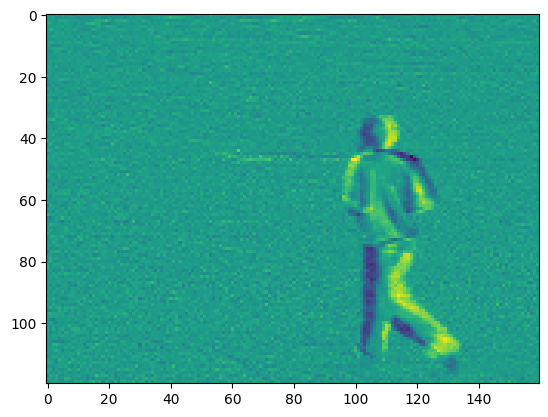

In [13]:
plt.imshow(iter(train_ds.take(1)).next()[0][0,20,:,:,0])

In [14]:
def build_model():
    x = tf.keras.Input(shape=(None, 120, 160, 1))

    out = tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu')(x)
    out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out)

    out = tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out)

    out = tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(out)

    out = tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None)(out)
    out = tf.keras.layers.GlobalAveragePooling3D()(out)

    out = tf.keras.layers.Dense(64, activation='relu')(out)

    out = tf.keras.layers.Dropout(0.3)(out)

    out = tf.keras.layers.Dense(6, activation='softmax')(out)

    return tf.keras.Model(inputs=x, outputs=out, name='video_model')

model = build_model()

In [15]:
model.summary()

Model: "video_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 120, 160,   0         
                             1)]                                 
                                                                 
 conv3d (Conv3D)             (None, None, 60, 80, 32)  4032      
                                                                 
 max_pooling3d (MaxPooling3D  (None, None, 30, 40, 32)  0        
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, None, 15, 20, 64)  256064    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, None, 8, 10, 64)  0         
 3D)                                                             
                                                       

In [16]:
LEARNING_RATE = 0.0001

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/model',
    write_graph=False, update_freq=10, profile_batch=0)

In [17]:
%%time
NUM_EPOCHS = 5

model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/5
199/199 [==============================] - 488s 2s/step - loss: 1.7918 - accuracy: 0.1910 - val_loss: 1.7874 - val_accuracy: 0.2353
Epoch 2/5
199/199 [==============================] - 166s 835ms/step - loss: 1.7463 - accuracy: 0.2613 - val_loss: 1.5786 - val_accuracy: 0.4510
Epoch 3/5
199/199 [==============================] - 167s 842ms/step - loss: 1.4224 - accuracy: 0.4171 - val_loss: 1.1962 - val_accuracy: 0.4706
Epoch 4/5
199/199 [==============================] - 166s 836ms/step - loss: 1.2542 - accuracy: 0.4322 - val_loss: 1.1170 - val_accuracy: 0.4314
Epoch 5/5
199/199 [==============================] - 167s 840ms/step - loss: 1.0774 - accuracy: 0.5327 - val_loss: 0.9815 - val_accuracy: 0.5294
CPU times: user 12min 42s, sys: 2min 57s, total: 15min 39s
Wall time: 21min 17s


In [18]:
%%time

score_train = model.evaluate(train_ds, verbose=0)
score_test = model.evaluate(test_ds, verbose=0)

print(f'Train: loss - {score_train[0]}, accuracy - {score_train[1]}')
print(f'Test: loss - {score_test[0]} accuracy - {score_test[1]}')

Train: loss - 0.9712250828742981, accuracy - 0.5778894424438477
Test: loss - 0.9869178533554077 accuracy - 0.5098039507865906
CPU times: user 48.4 s, sys: 34.3 s, total: 1min 22s
Wall time: 2min 37s


In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

Launching TensorBoard...

In [19]:
def check_model(test_ex, start=0):
  test_video, test_label = test_ex
  pred_label = model(test_video)
  pred_label = np.argmax(pred_label.numpy())
  example_label = np.argmax(test_label.numpy())
  print('True class:', test_label, '=', classes[example_label])
  print('Predicted class:', pred_label, '=', classes[pred_label])

  fig = plt.figure(figsize=(16, 8))
  for j in range(8):
      ax = fig.add_subplot(1, 8, j+1)
      ax.imshow(test_video[0, start+j*2, :, :, 0])
      plt.xticks([]), plt.yticks([])
  plt.show()

In [20]:
tests = list(test_ds.take(3))

True class: tf.Tensor([[0. 0. 0. 1. 0. 0.]], shape=(1, 6), dtype=float32) = boxing
Predicted class: 2 = running


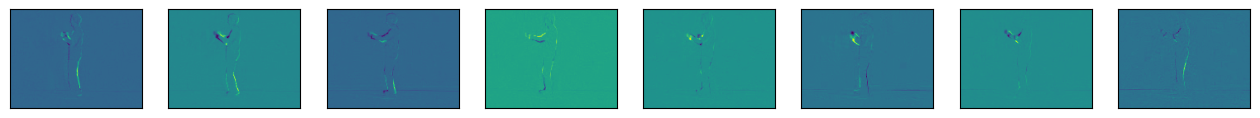

In [21]:
check_model(tests[0], 20)

In [22]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])

True class: running
Predicted class: running


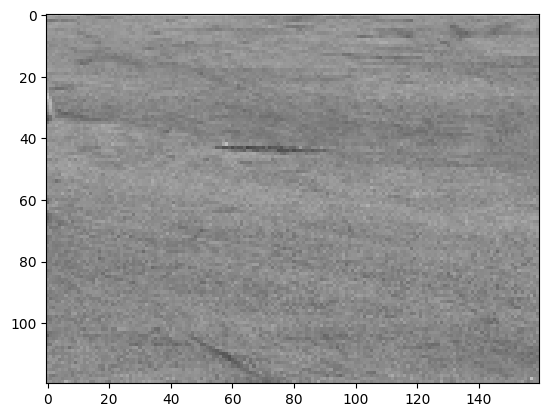

In [23]:
plt.imshow(videodata[40, ...])

In [24]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])

True class: handwaving
Predicted class: handwaving


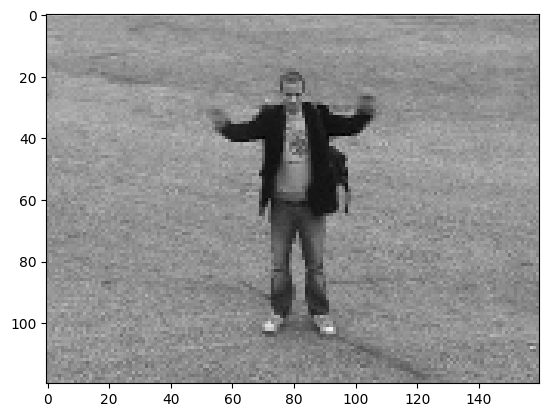

In [25]:
plt.imshow(videodata[40, ...])

In [26]:
fpath, cls_true = random.choice(dataset)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])

True class: running
Predicted class: walking


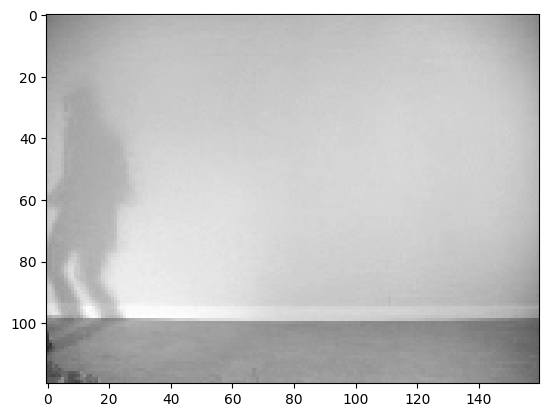

In [27]:
plt.imshow(videodata[40, ...])